# RAG Agent w/ Routing, Grading, Fallback & Self-correction

The idea of a RAG agent comes from combination of the following three elements into a single RAG Agent:

1. **Routing** --> Route questions to different retrieval approaches
2. **Grading** --> Re-rank search results using Reciprical Rank Fusion (RRF)
2. **WebSearch Fallback** --> Fallback to web search if there are no relevant documents to query 
3. **Self-correction** --> Minimization of hallucinations



In [2]:
# import modules

from langchain.text_splitter import NLTKTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

import os

# Azure OpenAI
from langchain_openai import AzureChatOpenAI

In [3]:
# OpenAI

AZURE_OPENAI_API_KEY = os.environ.get("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_ENDPOINT = os.environ.get('AZURE_OPENAI_ENDPOINT')
AZURE_OPENAI_VERSION = os.environ.get('AZURE_OPENAI_VERSION')
AZURE_OPENAI_DEPLOYMENT_NAME = os.environ.get('AZURE_OPENAI_DEPLOYMENT_NAME')

In [4]:
# load "cliamte change" data from /data/rag-agent-data

data_path = "data/rag-agent-data"
pdf_files = [f for f in os.listdir(data_path) if f.endswith('.pdf')]
docs = [PyPDFLoader(os.path.join(data_path, file)).load() for file in pdf_files]

print("Total documents: ", len(docs))
print(docs[2][0].page_content)

Total documents:  7
Earth Syst. Sci. Data, 15, 2295–2327, 2023
https://doi.org/10.5194/essd-15-2295-2023
© Author(s) 2023. This work is distributed under
the Creative Commons Attribution 4.0 License.
Indicators of Global Climate Change 2022: annual update
of large-scale indicators of the state of the climate
system and human inﬂuence
Piers M. Forster1, Christopher J. Smith1,2, Tristram Walsh3, William F. Lamb4,1, Robin Lamboll5,
Mathias Hauser6, Aurélien Ribes7, Debbie Rosen1, Nathan Gillett8, Matthew D. Palmer9,10,
Joeri Rogelj5, Karina von Schuckmann11, Sonia I. Seneviratne6, Blair Trewin12, Xuebin Zhang8,
Myles Allen3, Robbie Andrew13, Arlene Birt14, Alex Borger15, Tim Boyer16, Jiddu A. Broersma15,
Lijing Cheng17, Frank Dentener18, Pierre Friedlingstein19,20, José M. Gutiérrez21, Johannes Gütschow22,
Bradley Hall23, Masayoshi Ishii24, Stuart Jenkins3, Xin Lan22,44, June-Yi Lee25, Colin Morice9,
Christopher Kadow26, John Kennedy27, Rachel Killick9, Jan C. Minx4,1, Vaishali Naik28, Gl

In [5]:
# merge all the pages into a docs_list

docs_list = [item for sublist in docs for item in sublist]
print("Total pages: ", docs_list)

Total pages:  [Document(page_content='The Impact of Vehicle Automation  \non Carbon Emissions\nWhere Uncertainty Lies\nBy Myriam Alexander-Kearns, Miranda Peterson, and Alison Cassady  November 2016\n WWW.AMERICANPROGRESS.ORG\nAP PHOTO/JARED WICKERHAM', metadata={'source': 'data/rag-agent-data\\AutonomousVehicles-report.pdf', 'page': 0}), Document(page_content='The Impact of Vehicle \nAutomation on  \nCarbon Emissions\nWhere Uncertainty Lies\nBy Myriam Alexander-Kearns, Miranda Peterson, and Alison Cassady  \nNovember 2016', metadata={'source': 'data/rag-agent-data\\AutonomousVehicles-report.pdf', 'page': 1}), Document(page_content=' 1 Introduction and summary\n 4 What are autonomous vehicles?\n 6 Automakers and tech companies push forward  \nwith AV development\n 9 The Obama administration responds to AV development\n 11 Key research on environmental impacts of  \nautonomous vehicles\n 20 Recommendations for additional research\n 23 Conclusion\n 25 EndnotesContents', metadata={'source

In [6]:
# function for prettifying documents

def pretty_docs(docs):
    print(f"\n{'-'* 100}\n".join([F"##### DOC {i+1} #####\n\n" + d.page_content for i,d in enumerate(docs)]))

In [7]:
# init OpenAI (or any other open source model)

oai = AzureChatOpenAI(
    openai_api_version=AZURE_OPENAI_VERSION,
    azure_deployment=AZURE_OPENAI_DEPLOYMENT_NAME,
    temperature=0
)

## Semantic Chunking

In [8]:
# concatenate docs from list into a single string

text_splitter = NLTKTextSplitter()
doc_chunks = text_splitter.split_documents(docs_list)

print("Total no. of chunks: ", len(doc_chunks))

Total no. of chunks:  553


In [9]:
# extract only page_content from the chunks --> later use metadata from doc_chunks for the reference

clean_chunks = [doc.page_content for doc in doc_chunks]
print("Total no. of chunks: ", len(clean_chunks))

Total no. of chunks:  553


In [10]:
print(f"DOC CHUNK: {doc_chunks[32]}\n\n")
print(f"CLEAN CHUNK: {clean_chunks[32]}")

DOC CHUNK: page_content='27 Center for American Progress | The Impact of Vehicle Automation on Carbon Emissions\n 58 Google, “Google Self-Driving Car Project Monthly \nReport: January 2016” (2016), available at https://static.\n\ngoogleusercontent.com/media/www.google.com/en//\nselfdrivingcar/files/reports/report-0116.pdf .\n\n59 Federal Highway Administration, “Average Annual Miles per Driver by Age Group, ” available at https://www.\n\nfhwa.dot.gov/ohim/onh00/bar8.htm (last accessed \nNovember 2016).\n\n60 Anderson and others, “Autonomous Vehicle Technol-ogy.\n\n”\n 61 Ibid .\n\n62 Ibid.\n\n63 Anders Eugensson and others, “Environmental, Safety, Legal, and Societal Implications of Autonomous Driving Systems” (Gothenburg, Sweden: Volvo Car Corporation, \n2014), available at http://www-nrd.nhtsa.dot.gov/pdf/\nesv/esv23/23ESV-000467.PDF .\n\n64 Julia Piper, “Self-Driving Cars Could Cut Greenhouse Gas Pollution, ” Scientific American, September 15, 2014, \navailable at http://www.scienti

## Basic Retriever

In [11]:
# embedding model

emb_model = SentenceTransformerEmbeddings(model_name="thenlper/gte-large")

In [12]:
db = Chroma.from_documents(documents=doc_chunks, embedding=emb_model, collection_metadata={"hnsw:space": "cosine"})
retriever = db.as_retriever(search_type="mmr")

## Grading


In [13]:
# retrieve docs

user_query = "Autonomous vehicles and self-driving cards future"
docs = retriever.invoke(user_query)
docs

[Document(page_content='6 Center for American Progress | The Impact of Vehicle Automation on Carbon Emissions\nAutomakers and tech companies \npush forward with AV development\nAutomation and vehicle connectivity technology represent the largest transpor -\ntation sector disruption in decades.\n\nT o that end, automakers are racing to create \nvehicles with the advanced automation and connectivity technology needed to \nstake a claim in the emerging driverless car market.\n\nAutomaker investment in autonomous vehicles\nAutomakers are investing billions of dollars in the development and deployment of automated vehicle technologies.\n\nMost companies are already including auto -\nmated features in new models.\n\nFor example, Honda Motor Co. has included its Sensing suite of level 2 automated features in even its most affordable cars, such as the Civic.\n\n14 Similarly, the Volvo Group introduced its own level 2 package of \nfeatures called Pilot Assist with the release of its 2017 models

In [14]:
# Prompt for filtering erroneous irrelevant retrievals

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {user_query} \n
    """,
    input_variables=["user_query", "document"],
)

In [15]:
# test retrieval grader

# grading_llm = ChatOllama(model="llama3", format="json", temperature=0)
retrieval_grader = prompt | oai | JsonOutputParser()

input_data = {
    "user_query": user_query,
    "document": docs[0].page_content
}

retrieval_grader.invoke(input=input_data) # if "yes", the keywords are in the provided document --> most likely a relevant document

{'score': 'yes'}

In [16]:
# convert to function for grading documents

def grade_document_relevance(grader, user_query, documents):
    """
    Applies the retrieval grader to a list of documents to determine relevance to the user query.

    Args:
        user_query (str): The user's query.
        documents (list): A list of Langchain documents

    Returns:
        list: A list of Langchain documents that are deemed relevant (grading score is 'yes').
    """
    relevant_docs = []
    
    for doc in documents:
        input_data = {
            "user_query": user_query,
            "document": doc.page_content
        }
        
        # Invoke the retrieval grader with the constructed input
        try:
            result = grader.invoke(input=input_data)
            
            # Check if the score is 'yes'
            if result.get('score') == 'yes':
                relevant_docs.append(doc)
                
        except Exception as e:
            print(f"Error processing document: {e}")
    
    print(f"----- GRADER -----\nRELEVANT DOCUMENTS: {len(relevant_docs)} OUT OF {len(documents)}")

    return relevant_docs

In [17]:
relevant_docs = grade_document_relevance(grader=retrieval_grader, user_query=user_query, documents=docs)
relevant_docs

----- GRADER -----
RELEVANT DOCUMENTS: 4 OUT OF 4


[Document(page_content='6 Center for American Progress | The Impact of Vehicle Automation on Carbon Emissions\nAutomakers and tech companies \npush forward with AV development\nAutomation and vehicle connectivity technology represent the largest transpor -\ntation sector disruption in decades.\n\nT o that end, automakers are racing to create \nvehicles with the advanced automation and connectivity technology needed to \nstake a claim in the emerging driverless car market.\n\nAutomaker investment in autonomous vehicles\nAutomakers are investing billions of dollars in the development and deployment of automated vehicle technologies.\n\nMost companies are already including auto -\nmated features in new models.\n\nFor example, Honda Motor Co. has included its Sensing suite of level 2 automated features in even its most affordable cars, such as the Civic.\n\n14 Similarly, the Volvo Group introduced its own level 2 package of \nfeatures called Pilot Assist with the release of its 2017 models

## Re-ranking w/ RRF

Re-ranking of the results based on the distinct relevance indicators using simulation of **multiple similar search queries** similar to the initial user query.

Total of 5 queries (incl. initial user query).

**Main goals**: 
- improve performance of the search ranking
- mitigate the nuances and complexities of human queries

**RRF Formula**:

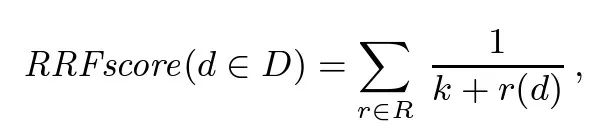

In [18]:
# STEP 1: create 5 similar user queries for RRF algo --> use OpenAI for better quality
from langchain_core.messages import HumanMessage
import ast

def generate_similar_search_queries(initial_query, documets):
    
    message = HumanMessage(
        content= f""" 
            You are a helpful search assistant. Your task is to generate four similar search queries in relation to the provided documents based on a single input query. 
            Always use provided output for your response. Be concise and constructive. Do not deviate from the context of the provided documents.
            

            Initial single input query: {initial_query}
            Documents: {documets}
            Output sturcture: ["{initial_query}", search query 1, search query 2, search query 3, search query 4]

        """,

    )
    response = oai.invoke([message])
    queries = ast.literal_eval(response.content)

    return queries


rff_queries = generate_similar_search_queries(initial_query=user_query,
                                           documets=relevant_docs)
rff_queries

['Autonomous vehicles and self-driving cards future',
 'Investments in autonomous vehicle technologies',
 'Impact of autonomous vehicles on carbon emissions',
 'Partnerships between ride-sharing companies and automakers for autonomous vehicles',
 'Future of electric and hybrid autonomous vehicles']

In [22]:
# STEP 2: build dictionaries for retrieved results incl. simulations

def generate_simulated_results(simulated_queries:list):

    all_queries_results = {}

    for query in simulated_queries:
        results = db.similarity_search_with_score(query, k=4)
        all_queries_results[query] = results

    return all_queries_results

sim_results = generate_simulated_results(rff_queries)
sim_results

{'Autonomous vehicles and self-driving cards future': [(Document(page_content='6 Center for American Progress | The Impact of Vehicle Automation on Carbon Emissions\nAutomakers and tech companies \npush forward with AV development\nAutomation and vehicle connectivity technology represent the largest transpor -\ntation sector disruption in decades.\n\nT o that end, automakers are racing to create \nvehicles with the advanced automation and connectivity technology needed to \nstake a claim in the emerging driverless car market.\n\nAutomaker investment in autonomous vehicles\nAutomakers are investing billions of dollars in the development and deployment of automated vehicle technologies.\n\nMost companies are already including auto -\nmated features in new models.\n\nFor example, Honda Motor Co. has included its Sensing suite of level 2 automated features in even its most affordable cars, such as the Civic.\n\n14 Similarly, the Volvo Group introduced its own level 2 package of \nfeatures 

In [23]:
# function to re-rank the search results into a unified result set

def reciprocal_rank_fusion(search_results_dict, k=5):
    """
    Applies reciprocal rank fusion on the provided search results dictionary.

    Args:
        search_results_dict (dict): A dictionary where each key is a query, and value is a list of (Document, score) tuples.
        k (int): The rank offset to apply in the reciprocal calculation.

    Returns:
        dict: A dictionary of documents (page content) with their fused scores and source, sorted in descending order of score.
    """
    fused_scores = {}

    for query, doc_scores in search_results_dict.items():
        for rank, (doc, score) in enumerate(sorted(doc_scores, key=lambda x: x[1], reverse=True)):
            doc_identifier = doc.page_content  # page content as unique identifier
            doc_source = doc.metadata.get('source', 'unknown')
            
            if doc_identifier not in fused_scores:
                fused_scores[doc_identifier] = [0, doc_source]
            
            # update the score
            fused_scores[doc_identifier][0] += 1 / (rank + k)

    # sort docs by fused score in descending order
    reranked_results = {doc: [score, source] for doc, (score, source) in sorted(fused_scores.items(), key=lambda x: x[1][0], reverse=True)}
    return reranked_results


reranked_results = reciprocal_rank_fusion(sim_results)
reranked_results

{'6 Center for American Progress | The Impact of Vehicle Automation on Carbon Emissions\nAutomakers and tech companies \npush forward with AV development\nAutomation and vehicle connectivity technology represent the largest transpor -\ntation sector disruption in decades.\n\nT o that end, automakers are racing to create \nvehicles with the advanced automation and connectivity technology needed to \nstake a claim in the emerging driverless car market.\n\nAutomaker investment in autonomous vehicles\nAutomakers are investing billions of dollars in the development and deployment of automated vehicle technologies.\n\nMost companies are already including auto -\nmated features in new models.\n\nFor example, Honda Motor Co. has included its Sensing suite of level 2 automated features in even its most affordable cars, such as the Civic.\n\n14 Similarly, the Volvo Group introduced its own level 2 package of \nfeatures called Pilot Assist with the release of its 2017 models.15 Nissan introduced 

## Initial Generation

In [ ]:
# generate an initial answer to user's query

## Hallucination Grading

In [ ]:
# grading the results and minimizing hallucinations w/ Llama 8B

hallucination_llm = ChatOllama(model="llama3", format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template = """ You are a grader assessing whether an answer is grounded in / supported by a set of facts. 
    Your task is to give a binary 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation. 
    
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}
    """,
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

## Final Generation

In [ ]:
# generate final answer to user's query


## Full Pipeline

In [ ]:
final_query = "Which years were selected for HadEX3 and why?"